In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/processed/weather_hourly.csv')

In [3]:
df.head()

,date,temperature_2m,wind_speed_10m,rain,snowfall,precipitation,wind_speed_100m
0,2023-01-01 04:00:00+00:00,10.6225,11.298495,1.0,0.0,1.0,24.400460
1,2023-01-01 05:00:00+00:00,10.3725,7.421590,1.0,0.0,1.0,19.917469
2,2023-01-01 06:00:00+00:00,10.3225,13.104197,0.1,0.0,0.1,27.343414
3,2023-01-01 07:00:00+00:00,10.2225,15.986595,0.0,0.0,0.0,31.319998
4,2023-01-01 08:00:00+00:00,9.5725,16.039202,0.0,0.0,0.0,32.744175


In [4]:
df.dtypes

date                object
temperature_2m     float64
wind_speed_10m     float64
rain               float64
snowfall           float64
precipitation      float64
wind_speed_100m    float64
dtype: object

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

## Feature Engineering for Weather Data

Let's create useful features from our weather data to better understand weather patterns and their impact on bike usage.

In [5]:
# Ensuring the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

In [6]:
# Display the data types
print("Data types before feature engineering:")
print(df.dtypes)
print(f"\nDataframe shape: {df.shape}")

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

# Basic statistics for numeric columns
print("\nBasic statistics:")
print(df.describe())

Data types before feature engineering:
date               datetime64[ns, UTC]
temperature_2m                 float64
wind_speed_10m                 float64
rain                           float64
snowfall                       float64
precipitation                  float64
wind_speed_100m                float64
dtype: object

Dataframe shape: (8760, 7)

Missing values:
No missing values

Basic statistics:
       temperature_2m  wind_speed_10m         rain     snowfall  \
count     8760.000000     8760.000000  8760.000000  8760.000000   
mean        12.778813       12.767678     0.169897     0.002541   
std          8.787757        6.549981     0.856628     0.041364   
min        -16.727500        0.000000     0.000000     0.000000   
25%          5.572500        7.895416     0.000000     0.000000   
50%         12.472500       11.525623     0.000000     0.000000   
75%         20.022500       16.599082     0.000000     0.000000   
max         35.672500       53.517845    26.900000     1

In [7]:
# 1. Temporal Features

# Extract date components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create time of day categories
time_bins = [0, 6, 12, 18, 24]
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['time_of_day'] = pd.cut(df['hour'], bins=time_bins, labels=time_labels, right=False)

# Create season based on month
season_map = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
    11: 'Fall', 12: 'Winter'
}
df['season'] = df['month'].map(season_map)

print("Temporal features created:")
for feature in ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'time_of_day', 'season']:
    if feature in df.columns:
        print(f"- {feature}")

Temporal features created:
- year
- month
- day
- hour
- day_of_week
- is_weekend
- time_of_day
- season


In [8]:
# 2. Temperature Features

# Create temperature categories
temp_bins = [-50, 0, 10, 20, 30, 50]  # Adjust based on your temperature range
temp_labels = ['Freezing', 'Cold', 'Mild', 'Warm', 'Hot']
df['temperature_category'] = pd.cut(df['temperature_2m'], bins=temp_bins, labels=temp_labels)

# Calculate temperature changes (delta from previous hour)
df['temperature_delta'] = df['temperature_2m'].diff()

# Flag for comfortable biking temperature (10-25°C is generally comfortable)
df['is_comfortable_temp'] = ((df['temperature_2m'] >= 10) & (df['temperature_2m'] <= 25)).astype(int)

print("\nTemperature features created:")
for feature in ['temperature_category', 'temperature_delta', 'is_comfortable_temp']:
    print(f"- {feature}")

# Show distribution of temperature categories
print("\nTemperature category distribution:")
print(df['temperature_category'].value_counts())


Temperature features created:
- temperature_category
- temperature_delta
- is_comfortable_temp

Temperature category distribution:
temperature_category
Cold        3041
Mild        2958
Warm        2080
Freezing     558
Hot          123
Name: count, dtype: int64


In [9]:
# 3. Wind Features

# Create wind categories for 10m height
wind_bins = [0, 5, 10, 15, 20, 100]  # Wind speed in km/h, adjust as needed
wind_labels = ['Calm', 'Light breeze', 'Moderate', 'Strong', 'Storm']
df['wind_category'] = pd.cut(df['wind_speed_10m'], bins=wind_bins, labels=wind_labels)

# Calculate wind ratio between 100m and 10m (can indicate stability)
df['wind_ratio'] = df['wind_speed_100m'] / df['wind_speed_10m'].clip(lower=0.1)

# Flag for windy conditions that might affect biking
df['is_windy'] = (df['wind_speed_10m'] > 15).astype(int)

print("\nWind features created:")
for feature in ['wind_category', 'wind_ratio', 'is_windy']:
    print(f"- {feature}")

# Show distribution of wind categories
print("\nWind category distribution:")
print(df['wind_category'].value_counts())


Wind features created:
- wind_category
- wind_ratio
- is_windy

Wind category distribution:
wind_category
Light breeze    2977
Moderate        2391
Strong          1587
Storm           1213
Calm             589
Name: count, dtype: int64


In [10]:
# 4. Precipitation Features

# Flag for any precipitation
df['has_precipitation'] = (df['precipitation'] > 0).astype(int)

# Flag for rain
df['is_rainy'] = (df['rain'] > 0).astype(int)

# Flag for snow
df['is_snowy'] = (df['snowfall'] > 0).astype(int)

# Create precipitation intensity categories
precip_bins = [0, 0.1, 2.5, 7.6, 50, 1000]  # in mm, following meteorological standards
precip_labels = ['None', 'Light', 'Moderate', 'Heavy', 'Extreme']
df['precipitation_category'] = pd.cut(df['precipitation'], bins=precip_bins, labels=precip_labels)

print("\nPrecipitation features created:")
for feature in ['has_precipitation', 'is_rainy', 'is_snowy', 'precipitation_category']:
    print(f"- {feature}")

# Show distribution of precipitation categories
print("\nPrecipitation category distribution:")
print(df['precipitation_category'].value_counts())


Precipitation features created:
- has_precipitation
- is_rainy
- is_snowy
- precipitation_category

Precipitation category distribution:
precipitation_category
Light       831
None        359
Moderate    133
Heavy        27
Extreme       0
Name: count, dtype: int64


In [13]:
# 5. Calculated Weather Metrics

# Calculate "feels like" temperature using wind chill and heat index
# Simple wind chill formula for temperatures below 10°C
mask_cold = df['temperature_2m'] < 10
df.loc[mask_cold, 'feels_like_temp'] = 13.12 + 0.6215 * df.loc[mask_cold, 'temperature_2m'] - \
                                      11.37 * (df.loc[mask_cold, 'wind_speed_10m'] ** 0.16) + \
                                      0.3965 * df.loc[mask_cold, 'temperature_2m'] * (df.loc[mask_cold, 'wind_speed_10m'] ** 0.16)

# For temperatures above 10°C, just use the actual temperature (simplified)
df.loc[~mask_cold, 'feels_like_temp'] = df.loc[~mask_cold, 'temperature_2m']

# Create a simple weather severity index (0-10 scale)
# Higher values mean worse weather for biking
# This combines temperature, wind and precipitation factors
df['weather_severity'] = (
    # Temperature factor (0-4): 0 for ideal temperature, 4 for extreme cold/hot
    4 - 4 * df['is_comfortable_temp'] +
    # Wind factor (0-3): Based on wind speed
    np.clip(df['wind_speed_10m'] / 10, 0, 3) + 
    # Precipitation factor (0-3): Based on precipitation amount
    np.clip(df['precipitation'] * 2, 0, 3)
).clip(0, 10)  # Ensure the index stays within 0-10 range

# Create "good biking weather" flag (low severity, no precipitation, comfortable temp)
df['is_good_biking_weather'] = ((df['weather_severity'] < 3) & 
                               (df['has_precipitation'] == 0) & 
                               (df['is_comfortable_temp'] == 1)).astype(int)

print("\nCalculated weather metrics created:")
for feature in ['feels_like_temp', 'weather_severity', 'is_good_biking_weather']:
    print(f"- {feature}")

# Show distribution of good biking weather
print("\nGood biking weather distribution:")
print(df['is_good_biking_weather'].value_counts())


Calculated weather metrics created:
- feels_like_temp
- weather_severity
- is_good_biking_weather

Good biking weather distribution:
is_good_biking_weather
0    5136
1    3624
Name: count, dtype: int64


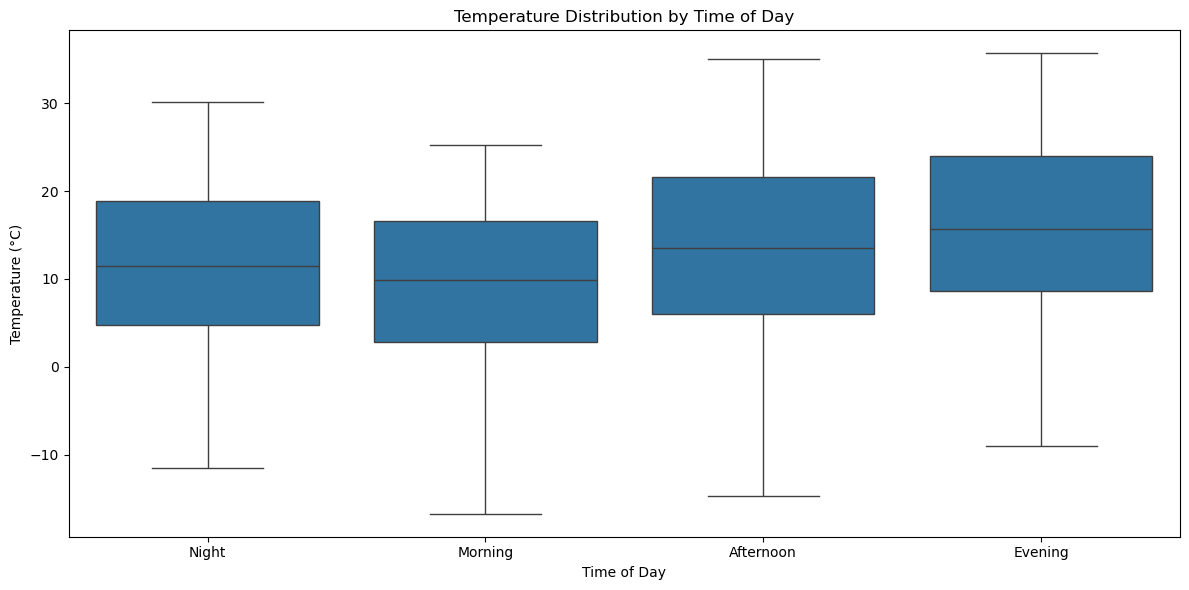

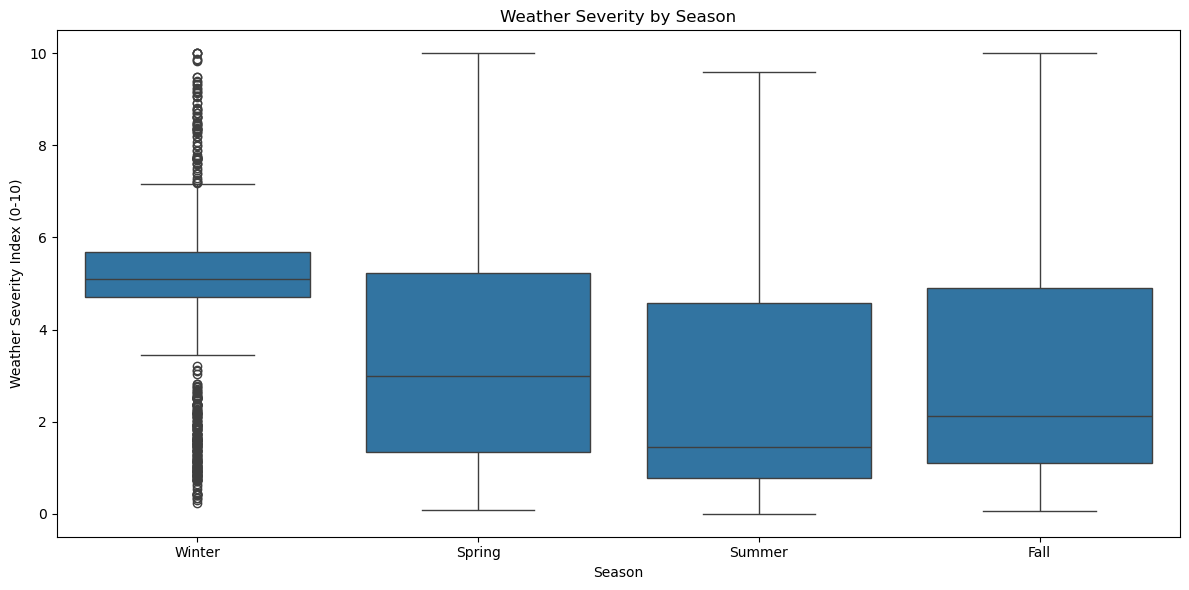

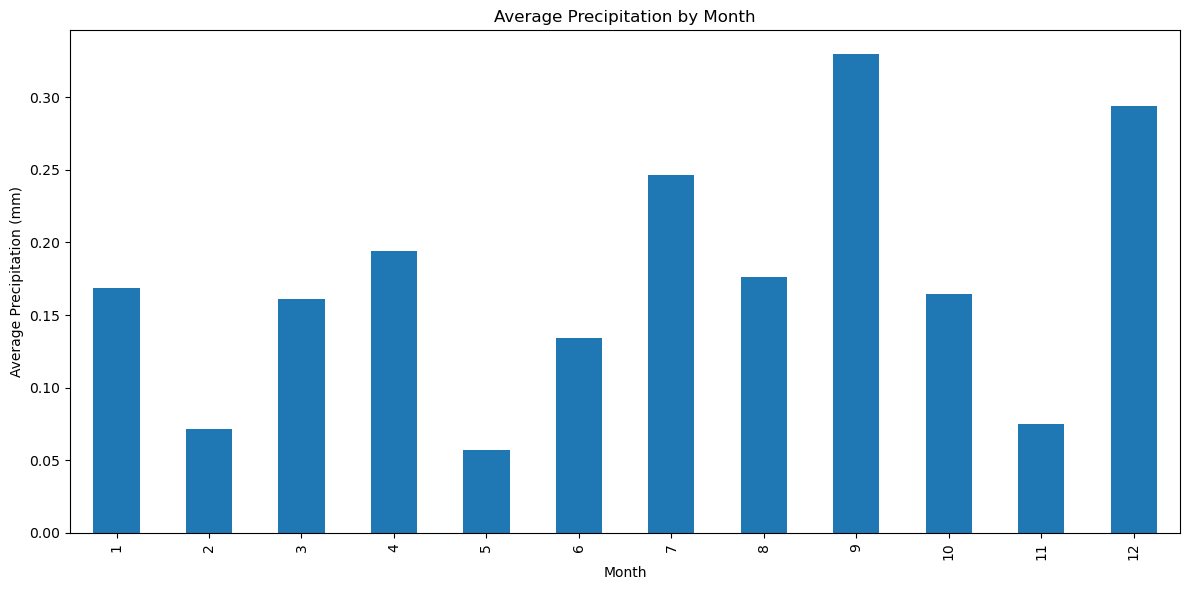

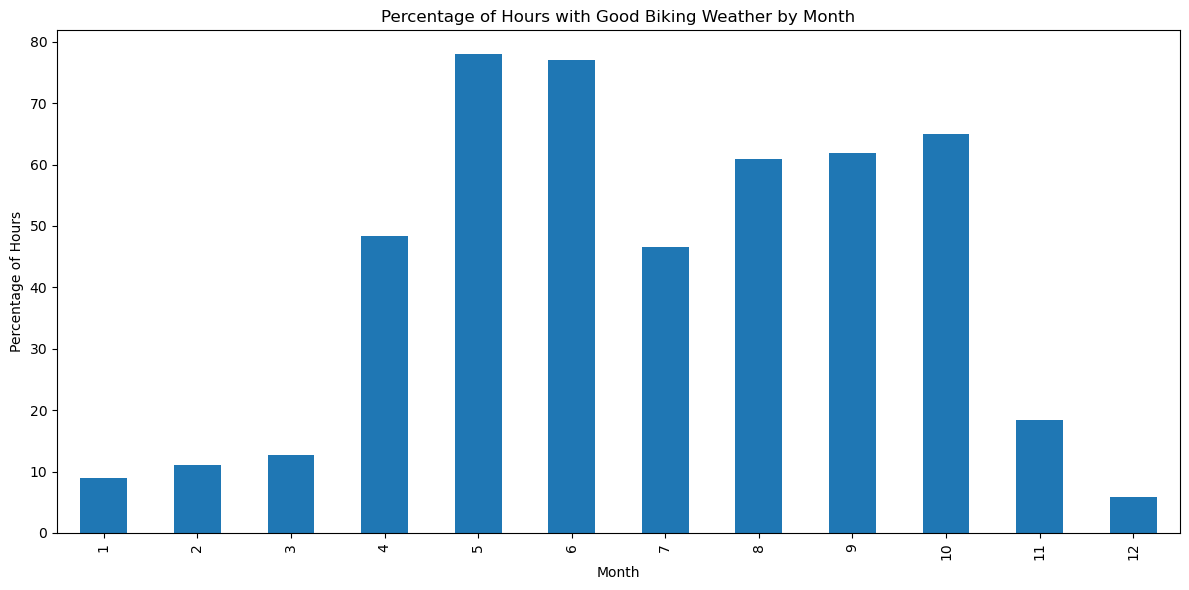

In [14]:
# Visualize key features

# 1. Temperature by time of day
plt.figure(figsize=(12, 6))
sns.boxplot(x='time_of_day', y='temperature_2m', data=df)
plt.title('Temperature Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()

# 2. Weather severity by season
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='weather_severity', data=df)
plt.title('Weather Severity by Season')
plt.xlabel('Season')
plt.ylabel('Weather Severity Index (0-10)')
plt.tight_layout()
plt.show()

# 3. Precipitation by month
monthly_precip = df.groupby('month')['precipitation'].mean()
plt.figure(figsize=(12, 6))
monthly_precip.plot(kind='bar')
plt.title('Average Precipitation by Month')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.tight_layout()
plt.show()

# 4. Good biking weather days by month
monthly_good_weather = df.groupby(['month', 'is_good_biking_weather']).size().unstack()
if 1 in monthly_good_weather.columns:  # Ensure the column exists
    monthly_good_weather_pct = monthly_good_weather[1] / monthly_good_weather.sum(axis=1) * 100
    plt.figure(figsize=(12, 6))
    monthly_good_weather_pct.plot(kind='bar')
    plt.title('Percentage of Hours with Good Biking Weather by Month')
    plt.xlabel('Month')
    plt.ylabel('Percentage of Hours')
    plt.tight_layout()
    plt.show()

## Save Engineered Weather Data

Now that we've created useful features from the weather data, let's save it for later use in our modeling.

In [16]:
# Create final data directory if it doesn't exist
final_data_dir = '../data/final/'
os.makedirs(final_data_dir, exist_ok=True)

# Generate a filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"weather_engineered_{timestamp}.csv"
output_path = os.path.join(final_data_dir, output_filename)

# Save the dataframe with all engineered features
df.to_csv(output_path, index=False)

# Provide summary of the saved data
num_features = len(df.columns)
num_rows = len(df)
file_size_mb = os.path.getsize(output_path) / (1024 * 1024)

print(f"Weather dataset successfully saved to: {output_path}")
print(f"Dataset summary:")
print(f"  - Rows: {num_rows:,}")
print(f"  - Features: {num_features}")
print(f"  - File size: {file_size_mb:.2f} MB")

# Create a simpler version without the timestamp for easier reference
standard_filename = "weather_engineered.csv"
standard_path = os.path.join(final_data_dir, standard_filename)
df.to_csv(standard_path, index=False)
print(f"\nAlso saved a reference copy to: {standard_path}")

# List all the features in the final dataset
print("\nFeatures in the final weather dataset:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

Weather dataset successfully saved to: ../data/final/weather_engineered_20250719_194427.csv
Dataset summary:
  - Rows: 8,760
  - Features: 28
  - File size: 1.55 MB

Also saved a reference copy to: ../data/final/weather_engineered.csv

Features in the final weather dataset:
  1. date
  2. temperature_2m
  3. wind_speed_10m
  4. rain
  5. snowfall
  6. precipitation
  7. wind_speed_100m
  8. year
  9. month
  10. day
  11. hour
  12. day_of_week
  13. is_weekend
  14. time_of_day
  15. season
  16. temperature_category
  17. temperature_delta
  18. is_comfortable_temp
  19. wind_category
  20. wind_ratio
  21. is_windy
  22. has_precipitation
  23. is_rainy
  24. is_snowy
  25. precipitation_category
  26. feels_like_temp
  27. weather_severity
  28. is_good_biking_weather
